In [2]:
import pandas as pd
import json
from pandas.io.json import json_normalize 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [3]:
file = open("/Users/Anushree/Desktop/Springboard/Take home challenge 2/amazon-meta.txt", "r")
file_list = file.read().split('\n\n')

In [4]:
file_list[1].split('\n')

['Id:   0', 'ASIN: 0771044445', '  discontinued product']

In [5]:
file_list[2].split('\n')

['Id:   1',
 'ASIN: 0827229534',
 '  title: Patterns of Preaching: A Sermon Sampler',
 '  group: Book',
 '  salesrank: 396585',
 '  similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X',
 '  categories: 2',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]',
 '  reviews: total: 2  downloaded: 2  avg rating: 5',
 '    2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9',
 '    2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5']

In [6]:
d= {}
d['categories'] = []
l = '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]'
items = l.split(":")
key = re.sub(pattern=' ',repl= '',string=items[0]) 
key
d['categories'].append({'category': key})
d

{'categories': [{'category': '|Books[283155]|Subjects[1000]|Religion&Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]'}]}

In [7]:
def get_dict(list_lines, splits ):
    d = {}
    if len(list_lines) > 8: 
        d['individuals'] = []
        d['cat_entries'] = []
        
    for i in range(len(list_lines)):
        line = list_lines[i]
        items = line.split(splits)
        
        
        key = re.sub(pattern=' ',repl= '',string=items[0]) 
        
        if '|' in items[0][:10]: 
            d['cat_entries'].append({'category': key})  
            
        elif len(items) < 4:
            value = ':'.join(items[1:])
            d[key] = value
        else:
            # put the items back to its original form
            temp_value = ':'.join(items[1:])
            
            if key[-5:]== 'tomer':
                temp_value = 'date:' + ':'.join(items) 
                #key = 'individuals:' # master layer to all the inidividual reviews

            nest_dict = get_dict(re.findall(r"\w+:\s+\S+", temp_value), ':')
            if key[-5:]== 'tomer':
                d['individuals'].append(nest_dict) # nested reviews
            else: 
                d[key] = nest_dict 
    return d
get_dict(file_list[2].split('\n'), ':')

{'ASIN': ' 0827229534',
 'Id': '   1',
 'cat_entries': [{'category': '|Books[283155]|Subjects[1000]|Religion&Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]'},
  {'category': '|Books[283155]|Subjects[1000]|Religion&Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]'}],
 'categories': ' 2',
 'group': ' Book',
 'individuals': [{'cutomer': ' A2JW67OY8U6HHK',
   'date': '    2000-7-28',
   'helpful': '   9',
   'rating': ' 5',
   'votes': '  10'},
  {'cutomer': ' A2VE83MZF98ITY',
   'date': '    2003-12-14',
   'helpful': '   5',
   'rating': ' 5',
   'votes': '   6'}],
 'reviews': {'downloaded': ' 2', 'rating': ' 5', 'total': ' 2'},
 'salesrank': ' 396585',
 'similar': ' 5  0804215715  156101074X  0687023955  0687074231  082721619X',
 'title': ' Patterns of Preaching: A Sermon Sampler'}

In [8]:
dict_all = [get_dict(l.split('\n'), ':') for l in file_list if len(l.split('\n')) > 8]

In [9]:
dict_all[2].keys()

dict_keys(['individuals', 'cat_entries', 'Id', 'ASIN', 'title', 'group', 'salesrank', 'similar', 'categories', 'reviews'])

In [10]:
with open('meta-data.json', 'w') as outfile:

    json.dump([dict(k) for k in dict_all],outfile)

In [11]:
data = json_normalize(dict_all, 'individuals', 
                          ['Id','ASIN','title','group','categories','salesrank','similar',['reviews','total']])

In [12]:
data.head()

,cutomer,date,helpful,rating,votes,Id,ASIN,title,group,categories,salesrank,similar,reviews.total
0,A2JW67OY8U6HHK,2000-7-28,9,5,10,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,2,396585,5 0804215715 156101074X 0687023955 068707...,2
1,A2VE83MZF98ITY,2003-12-14,5,5,6,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,2,396585,5 0804215715 156101074X 0687023955 068707...,2
2,A11NCO6YTE4BTJ,2001-12-16,4,5,5,2,0738700797,Candlemas: Feast of Flames,Book,2,168596,5 0738700827 1567184960 1567182836 073870...,12
3,A9CQ3PLRNIR83,2002-1-7,5,4,5,2,0738700797,Candlemas: Feast of Flames,Book,2,168596,5 0738700827 1567184960 1567182836 073870...,12
4,A13SG9ACZ9O5IM,2002-1-24,8,5,8,2,0738700797,Candlemas: Feast of Flames,Book,2,168596,5 0738700827 1567184960 1567182836 073870...,12


In [ ]:
data.to_csv('meta-data_raw.csv')

In [13]:
data.rating = data.rating.astype(int)
data.salesrank = data.salesrank.astype(int)

In [14]:
avg_rating = data.groupby('ASIN', as_index=False)[['rating', 'salesrank']].aggregate(np.mean)

In [15]:
avg_rating.head()

,ASIN,rating,salesrank
0,0001047655,3.766667,1116690.0
1,0001053736,4.600000,53150.0
2,0001053744,5.000000,500890.0
3,0001054600,4.159574,2449141.0
4,0001057170,3.500000,708137.0


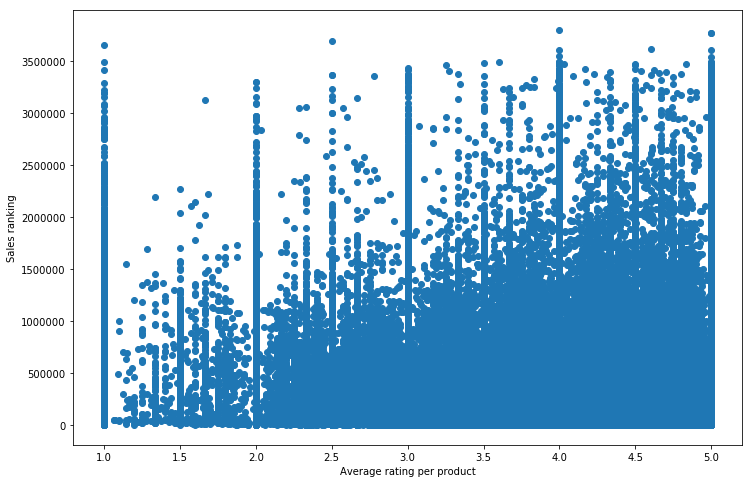

In [19]:
plt.figure(figsize=(12,8))
plt.scatter(avg_rating.rating, avg_rating.salesrank)
plt.xlabel('Average rating per product')
plt.ylabel('Sales ranking')
plt.show()

FRom the scatter plot above we can see that lower rating products have higher sales ranking. Therefore we can conclude that sales ranking is not indicative of the popularity of the products.

In [17]:
avg_rating.corr()

,rating,salesrank
rating,1.000000,-0.017756
salesrank,-0.017756,1.000000


In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
m = ols('salesrank ~ rating', avg_rating).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:              salesrank   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     127.0
Date:                Thu, 03 Aug 2017   Prob (F-statistic):           1.87e-29
Time:                        15:35:35   Log-Likelihood:            -5.7680e+06
No. Observations:              402724   AIC:                         1.154e+07
Df Residuals:                  402722   BIC:                         1.154e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.945e+05   3777.820    104.412      0.0

Consider the product group named 'Books'.
a. Is there redundancy in the categorization? How can it be identified/removed?
b. Is is possible to reduce the number of categories drastically (say to 10% of existing categories) by sacrificing relatively few category entries (say close to 10%)?

In [23]:
category = json_normalize(dict_all, 'cat_entries', 
                          ['ASIN','group','categories'])

In [24]:
category.head()

,category,ASIN,group,categories
0,|Books[283155]|Subjects[1000]|Religion&Spiritu...,0827229534,Book,2
1,|Books[283155]|Subjects[1000]|Religion&Spiritu...,0827229534,Book,2
2,|Books[283155]|Subjects[1000]|Religion&Spiritu...,0738700797,Book,2
3,|Books[283155]|Subjects[1000]|Religion&Spiritu...,0738700797,Book,2
4,|Books[283155]|Subjects[1000]|Home&Garden[48]|...,0486287785,Book,1


In [25]:
category.group.unique()

array([' Book', ' Music', ' DVD', ' Video', ' Toy', ' Video Games',
       ' Software', ' Baby Product', ' CE', ' Sports'], dtype=object)

In [26]:
category.group = category.group.astype(str)
category.group = category.group.apply(lambda x: re.sub(' ','', x))

In [28]:
books_data = category.loc[category['group']=="Book",: ]
books_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440329 entries, 0 to 2509689
Data columns (total 4 columns):
category      1440329 non-null object
ASIN          1440329 non-null object
group         1440329 non-null object
categories    1440329 non-null object
dtypes: object(4)
memory usage: 54.9+ MB


In [29]:
books_data.category = books_data.category.astype(str)
books_data.ASIN = books_data.ASIN.astype(str)
books_data.categories = books_data.categories.astype(int)

print('Total products',len(books_data.ASIN.unique()))
print('Total categories', len(books_data.category.unique()))

/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Total products 375139
Total categories 12849


Since the number of categories account upto 4% of the total products. Redundant categoreis can be removed according to the representation of that category in the whole dataset.

In [30]:
all_category = books_data.category.apply(
                    lambda x: re.findall('[a-zA-Z]+',x))

In [31]:
all_category[:5]

0    [Books, Subjects, Religion, Spirituality, Chri...
1    [Books, Subjects, Religion, Spirituality, Chri...
2    [Books, Subjects, Religion, Spirituality, Eart...
3    [Books, Subjects, Religion, Spirituality, Eart...
4    [Books, Subjects, Home, Garden, Crafts, Hobbie...
Name: category, dtype: object

In [32]:
L = all_category.as_matrix()
catNames = [item for sublist in L for item in sublist]
n_catNames = len(set(catNames))
print("Number of unique category names:" , n_catNames)

Number of unique category names: 9118


In [33]:
new_category =pd.DataFrame({'Original': all_category.apply(lambda x: '_'.join(x)),
                        'Level_1': all_category.apply(lambda x: x[-1]),
                        'Level_2': all_category.apply(lambda x: x[-2]),
                        'Level_no1': all_category.apply(lambda x: '_'.join(x[:-1])),
                        'Level_no2': all_category.apply(lambda x: '_'.join(x[:-2]))
                       }, dtype = str) 
new_category.head()

,Level_1,Level_2,Level_no1,Level_no2,Original
0,Preaching,Clergy,Books_Subjects_Religion_Spirituality_Christian...,Books_Subjects_Religion_Spirituality_Christianity,Books_Subjects_Religion_Spirituality_Christian...
1,Sermons,Clergy,Books_Subjects_Religion_Spirituality_Christian...,Books_Subjects_Religion_Spirituality_Christianity,Books_Subjects_Religion_Spirituality_Christian...
2,Wicca,BasedReligions,Books_Subjects_Religion_Spirituality_Earth_Bas...,Books_Subjects_Religion_Spirituality_Earth,Books_Subjects_Religion_Spirituality_Earth_Bas...
3,Witchcraft,BasedReligions,Books_Subjects_Religion_Spirituality_Earth_Bas...,Books_Subjects_Religion_Spirituality_Earth,Books_Subjects_Religion_Spirituality_Earth_Bas...
4,General,Hobbies,Books_Subjects_Home_Garden_Crafts_Hobbies,Books_Subjects_Home_Garden_Crafts,Books_Subjects_Home_Garden_Crafts_Hobbies_General


In [44]:
size_rest = new_category.drop_duplicates(
                                    subset='Original').groupby('Level_no1').size(
                ).sort_values(ascending = False)
size_rest

Level_no1
Books_Subjects_Reference_Dictionaries_Thesauruses_ForeignLanguage                               52
Books_Subjects_Home_Garden_Crafts_Hobbies                                                       49
Books_Formats_SheetMusic_Scores_Composers                                                       43
Books_Subjects_Health_Mind_Body_Disorders_Diseases                                              41
Books_Subjects_History_Africa                                                                   40
Books_Subjects_History_Europe                                                                   40
Books_Subjects_History_Americas_UnitedStates_State_Local_ByState                                36
Books_Subjects_Home_Garden_Antiques_Collectibles                                                34
Books_Subjects_Travel_GuidebookSeries                                                           30
Amazon_comStores_Travel_Categories_TravelBooks_GuidebookSeries                                  30


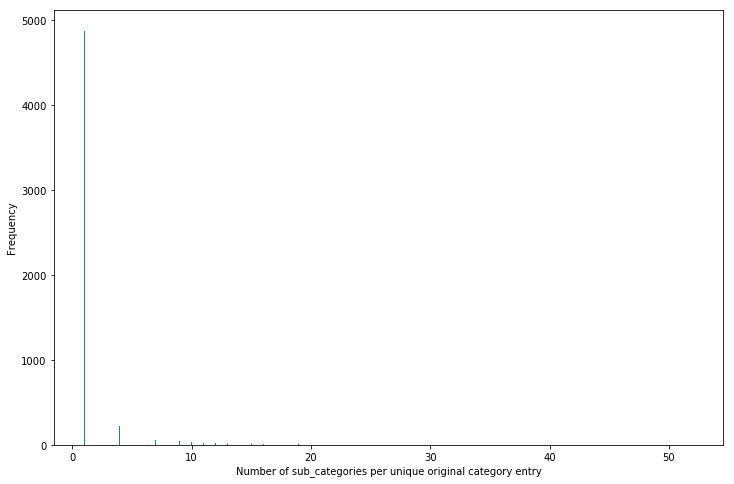

In [46]:
plt.figure(figsize=(12,8))
plt.hist(size_rest, 1000) # set 1000 bins
plt.xlabel('Number of sub_categories per unique original category entry')
plt.ylabel('Frequency')
plt.show()

When one sub category per category entry is there, we can remove that sub-category.

In [36]:
n_original = len(new_category.Original.unique())
print('The number of categories with one sub-category:',
 sum(size_rest<2))
print('\nThe original unique category entries:' , n_original)

The number of categories with one sub-category: 4876

The original unique category entries: 12786


4876 is 53% of the unique category names. So if we remove it, the number of unique category entries remain the same.

In [38]:
size_rest_sub = new_category.loc[new_category.Level_no1.isin(size_rest.index.values[size_rest==1]), :].groupby(
    'Level_no2').size().sort_values(ascending = False)
size_rest_sub

Level_no2
Amazon_comStores_Home_Office_Business                                                             18438
Books_Subjects_Business                                                                           18436
Books_Subjects_Computers                                                                           8660
Books_SpecialtyStores                                                                              7896
Books_Subjects_Computers_Internet                                                                  5201
Books_Subjects_Children_sBooks_Literature                                                          4097
Books_Subjects_Nonfiction_Politics                                                                 3413
Books_Subjects_History_Americas_UnitedStates                                                       3392
Books_Subjects_Children_sBooks_Literature_ScienceFiction_Fantasy_Mystery_Horror_ScienceFiction     3286
Books_Subjects_Religion_Spirituality_Christianity_Refe

In [39]:
print('The number of categories with one sub-category in the last two layers:',
 sum(size_rest_sub == 1))

The number of categories with one sub-category in the last two layers: 155


Together it becomes 5031(4876+155) which is 55%of the unique category names.

In [40]:
print('The number of categories with two sub-category:',
 sum(size_rest == 2))

The number of categories with two sub-category: 461


In [41]:
print(n_original)
n_catNames

12786


9118

Now the total will be 4876+155+461*2 = 5953(65% unique category names). The number of unique category entries now reduces by 461, or 3.6%.

In [42]:
print('The number of categories with two sub-category second to last category:',
 sum(size_rest_sub == 2))

The number of categories with two sub-category second to last category: 62


Total is: 4876 + 155 + 461 *2 + 62 * 2 = 6077 categories (67% of unique category names), the number of unique category entries reduces by 461 + 62, or 4.1%.
And we can continue this on and on until 90% of categories are removed with less than 10% of category entries lost.

In [43]:
print('The number of categories with three sub-category :',
 sum(size_rest == 3))

The number of categories with three sub-category : 319


Now the total is : 4876 + 155 + 461*2 + 62*2 + 319*3 = 7034 categories (77% of unique category names), the number of unique category entries reduces by 461 + 62 + 319*2 = 1161, or 9%.

To remove closer to 90% of the entries you have to get rid of about 25% of the categories.

a. Is it a good idea to show users the categorization hierarchy for items? I don't think it's necessary to give the users the categorization hierarchy and therefore wouldn't day it's a good idea.

b. Is it a good idea to show users similar/co-purchased items? Yes. I think it's always good to show similiar items since it gives the user more choice and also more felxibility.

c. Is it a good idea to show users reviews and ratings for items? Yes. I think it's a good idea to show users reviews and ratings to better help them make a purchase according to their choice and need.

d. For each of the above, why? How will you establish the same? We can do a A/B testing to see what works and what doesn't and finally implement that.